In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def listdir(path, exclude=[]):
    return [os.path.join(path, f) for f in os.listdir(path) if all(ex not in f for ex in exclude)]

plt.rcParams['figure.dpi'] = 250
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['figure.subplot.top'] = 0.92  # Add default padding between suptitles and axes
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.title_fontsize'] = 16
plt.rcParams['axes.grid'] = True

warm_colors = sns.color_palette("dark:tomato_r", n_colors=4)
cool_colors = sns.color_palette("dark:dodgerblue_r", n_colors=5)

# Visualizations: Summary + Q&A Evals

In [2]:
eval_path = "/n/holylabs/LABS/hlakkaraju_lab/Users/lilliansun/cs2281_synthetic_data/eval_results/"
loss_path = "/n/holylabs/LABS/hlakkaraju_lab/Users/lilliansun/cs2281_synthetic_data/results/"

## Summary

In [9]:
summary_path = os.path.join(eval_path, "summarize")
summary_jobs = listdir(summary_path, exclude=[".DS_Store", "args.json", "baseline.csv"])
summary_baseline = pd.read_csv(os.path.join(summary_path, "baseline.csv"), header=None)

In [10]:
summary_df = []

for job in summary_jobs:
    df = pd.read_csv(os.path.join(job, "evaluation_results.csv"), header=None)
    df.columns = ["checkpoint_name", "keyword_pct"]
    df["step"] = df["checkpoint_name"].apply(lambda x: int(x.split("-")[-1]))
    df.drop("checkpoint_name", axis=1, inplace=True)

    # add baseline
    baseline_keyword_pct = summary_baseline.loc[summary_baseline[0] == f"google/flan-{job.split('/')[-1].split('_')[0]}", 1].values[0]
    df = pd.concat([pd.DataFrame({"keyword_pct": [baseline_keyword_pct], "step": [0]}), df], ignore_index=True)

    df["model"] = job.split("/")[-1].split("_")[0]
    df["human"] = "human" in job

    if (
        os.path.basename(job) == "t5-small_1_no_eval"
        or os.path.basename(job) == "t5-small_1_no_eval_2"
        or os.path.basename(job) == "t5-small_1_no_eval_3"
    ):
        df = df[df["step"] % 160 == 0]
        df["step"] = df["step"] // 4
        
    loss_df = pd.read_csv(os.path.join(loss_path, "summarization", "cleaned", f"{os.path.basename(job)}_train.csv"))
    df = df.merge(loss_df[['step', 'loss']], on='step', how='left')

    summary_df.append(df)

summary_df = pd.concat(summary_df)

In [208]:
len(df)

22

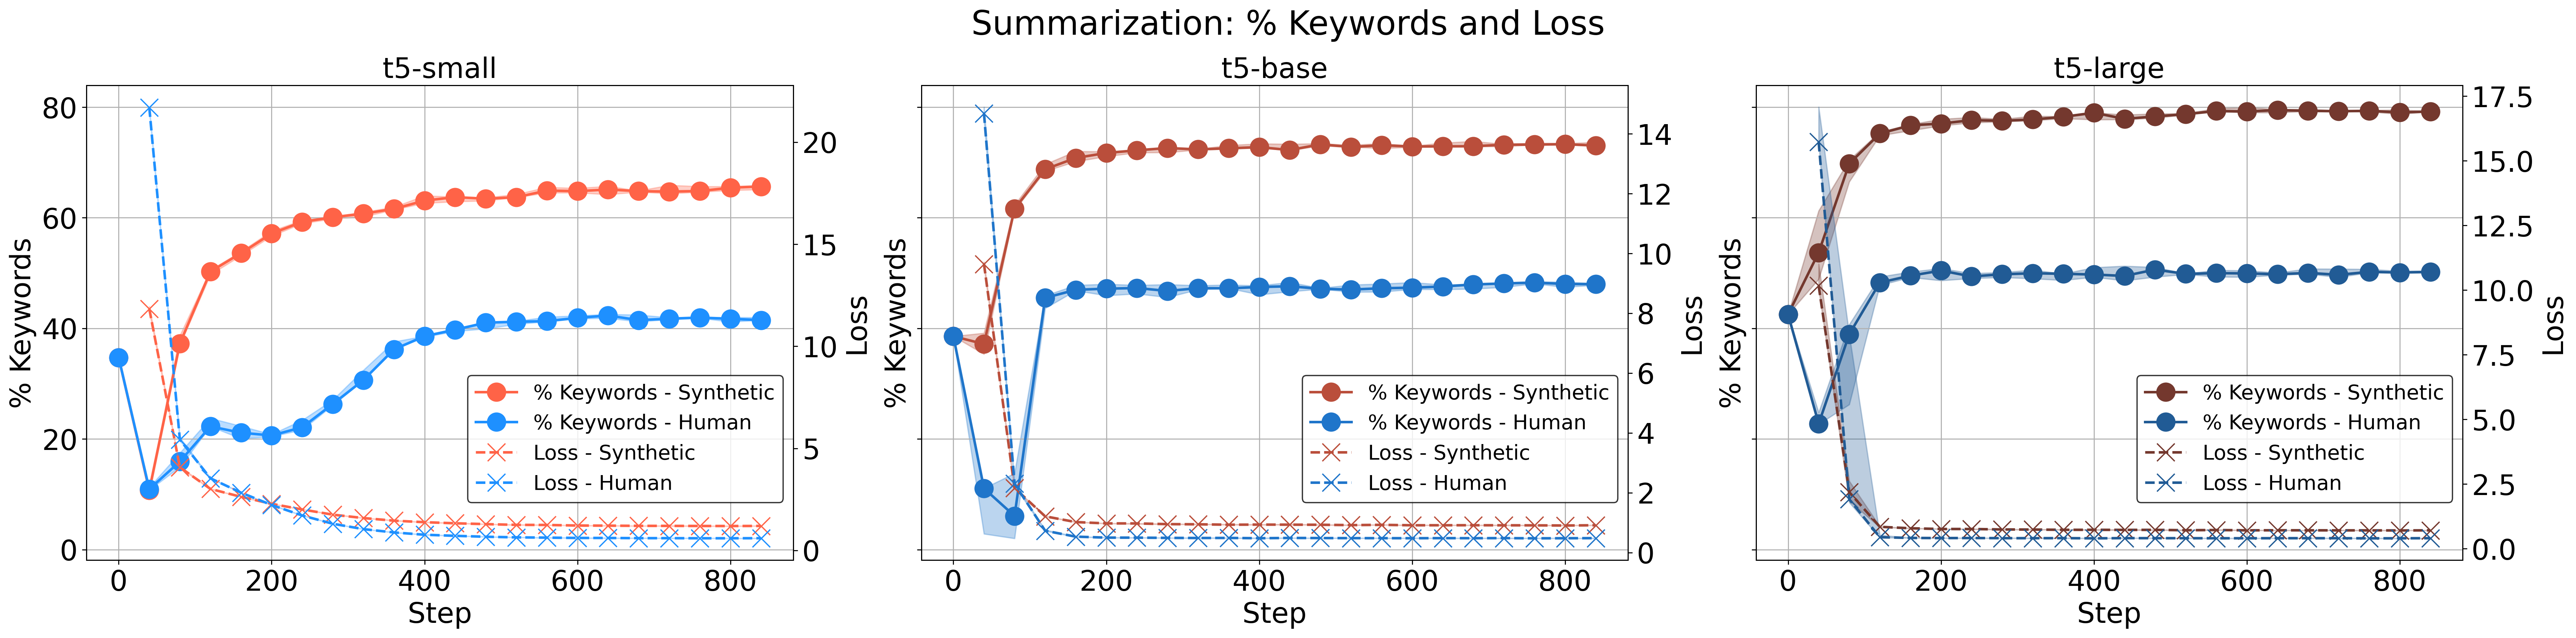

In [11]:
# Group by model and human, then calculate min, median, and max
summary_grouped = summary_df.groupby(["model", "human", "step"]).agg({"keyword_pct": ["min", "median", "max"], "loss": ["min", "median", "max"]}).reset_index()
summary_grouped.columns = ["model", "human", "step", "min_keyword_pct", "median_keyword_pct", "max_keyword_pct", "min_loss", "median_loss", "max_loss"]

# Create a dictionary to map models to colors
model_colors = {}
model_order = ["t5-small", "t5-base", "t5-large"]
for i, model in enumerate(model_order):
    model_colors[(model, False)] = warm_colors[i]
    model_colors[(model, True)] = cool_colors[i]

# Sort the summary_grouped DataFrame by model order
summary_grouped['model'] = pd.Categorical(summary_grouped['model'], categories=model_order, ordered=True)
summary_grouped = summary_grouped.sort_values(['model', 'human', 'step'])

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 7), sharex=True, sharey=True)
axes = axes.flatten()

# Plotting
for idx, model in enumerate(model_order):
    ax2 = axes[idx].twinx()  # Create secondary axis once per subplot
    for human in [False, True]:
        data = summary_grouped[(summary_grouped["model"] == model) & (summary_grouped["human"] == human)]
        label_keywords = f"% Keywords - {'Human' if human else 'Synthetic'}"
        label_loss = f"Loss - {'Human' if human else 'Synthetic'}"
        color = model_colors[(model, human)]
        axes[idx].plot(data["step"], data["median_keyword_pct"], label=label_keywords, color=color, marker='o', linestyle='-', markersize=14, linewidth=2)
        axes[idx].fill_between(data["step"], data["min_keyword_pct"], data["max_keyword_pct"], color=color, alpha=0.3)
        ax2.plot(data["step"], data["median_loss"], label=label_loss, color=color, linestyle='--', marker='x', markersize=14, linewidth=2)
        ax2.fill_between(data["step"], data["min_loss"], data["max_loss"], color=color, alpha=0.3)
        ax2.set_ylabel("Loss")
        axes[idx].set_title(model)
        axes[idx].set_xlabel("Step")
        axes[idx].set_ylabel("% Keywords")
    ax2.grid(False) 

    # Combine legends
    lines, labels = axes[idx].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axes[idx].legend(lines + lines2, labels + labels2, loc='lower right', bbox_to_anchor=(1, 0.1), edgecolor="black")

plt.suptitle("Summarization: % Keywords and Loss")
plt.tight_layout()
plt.show()


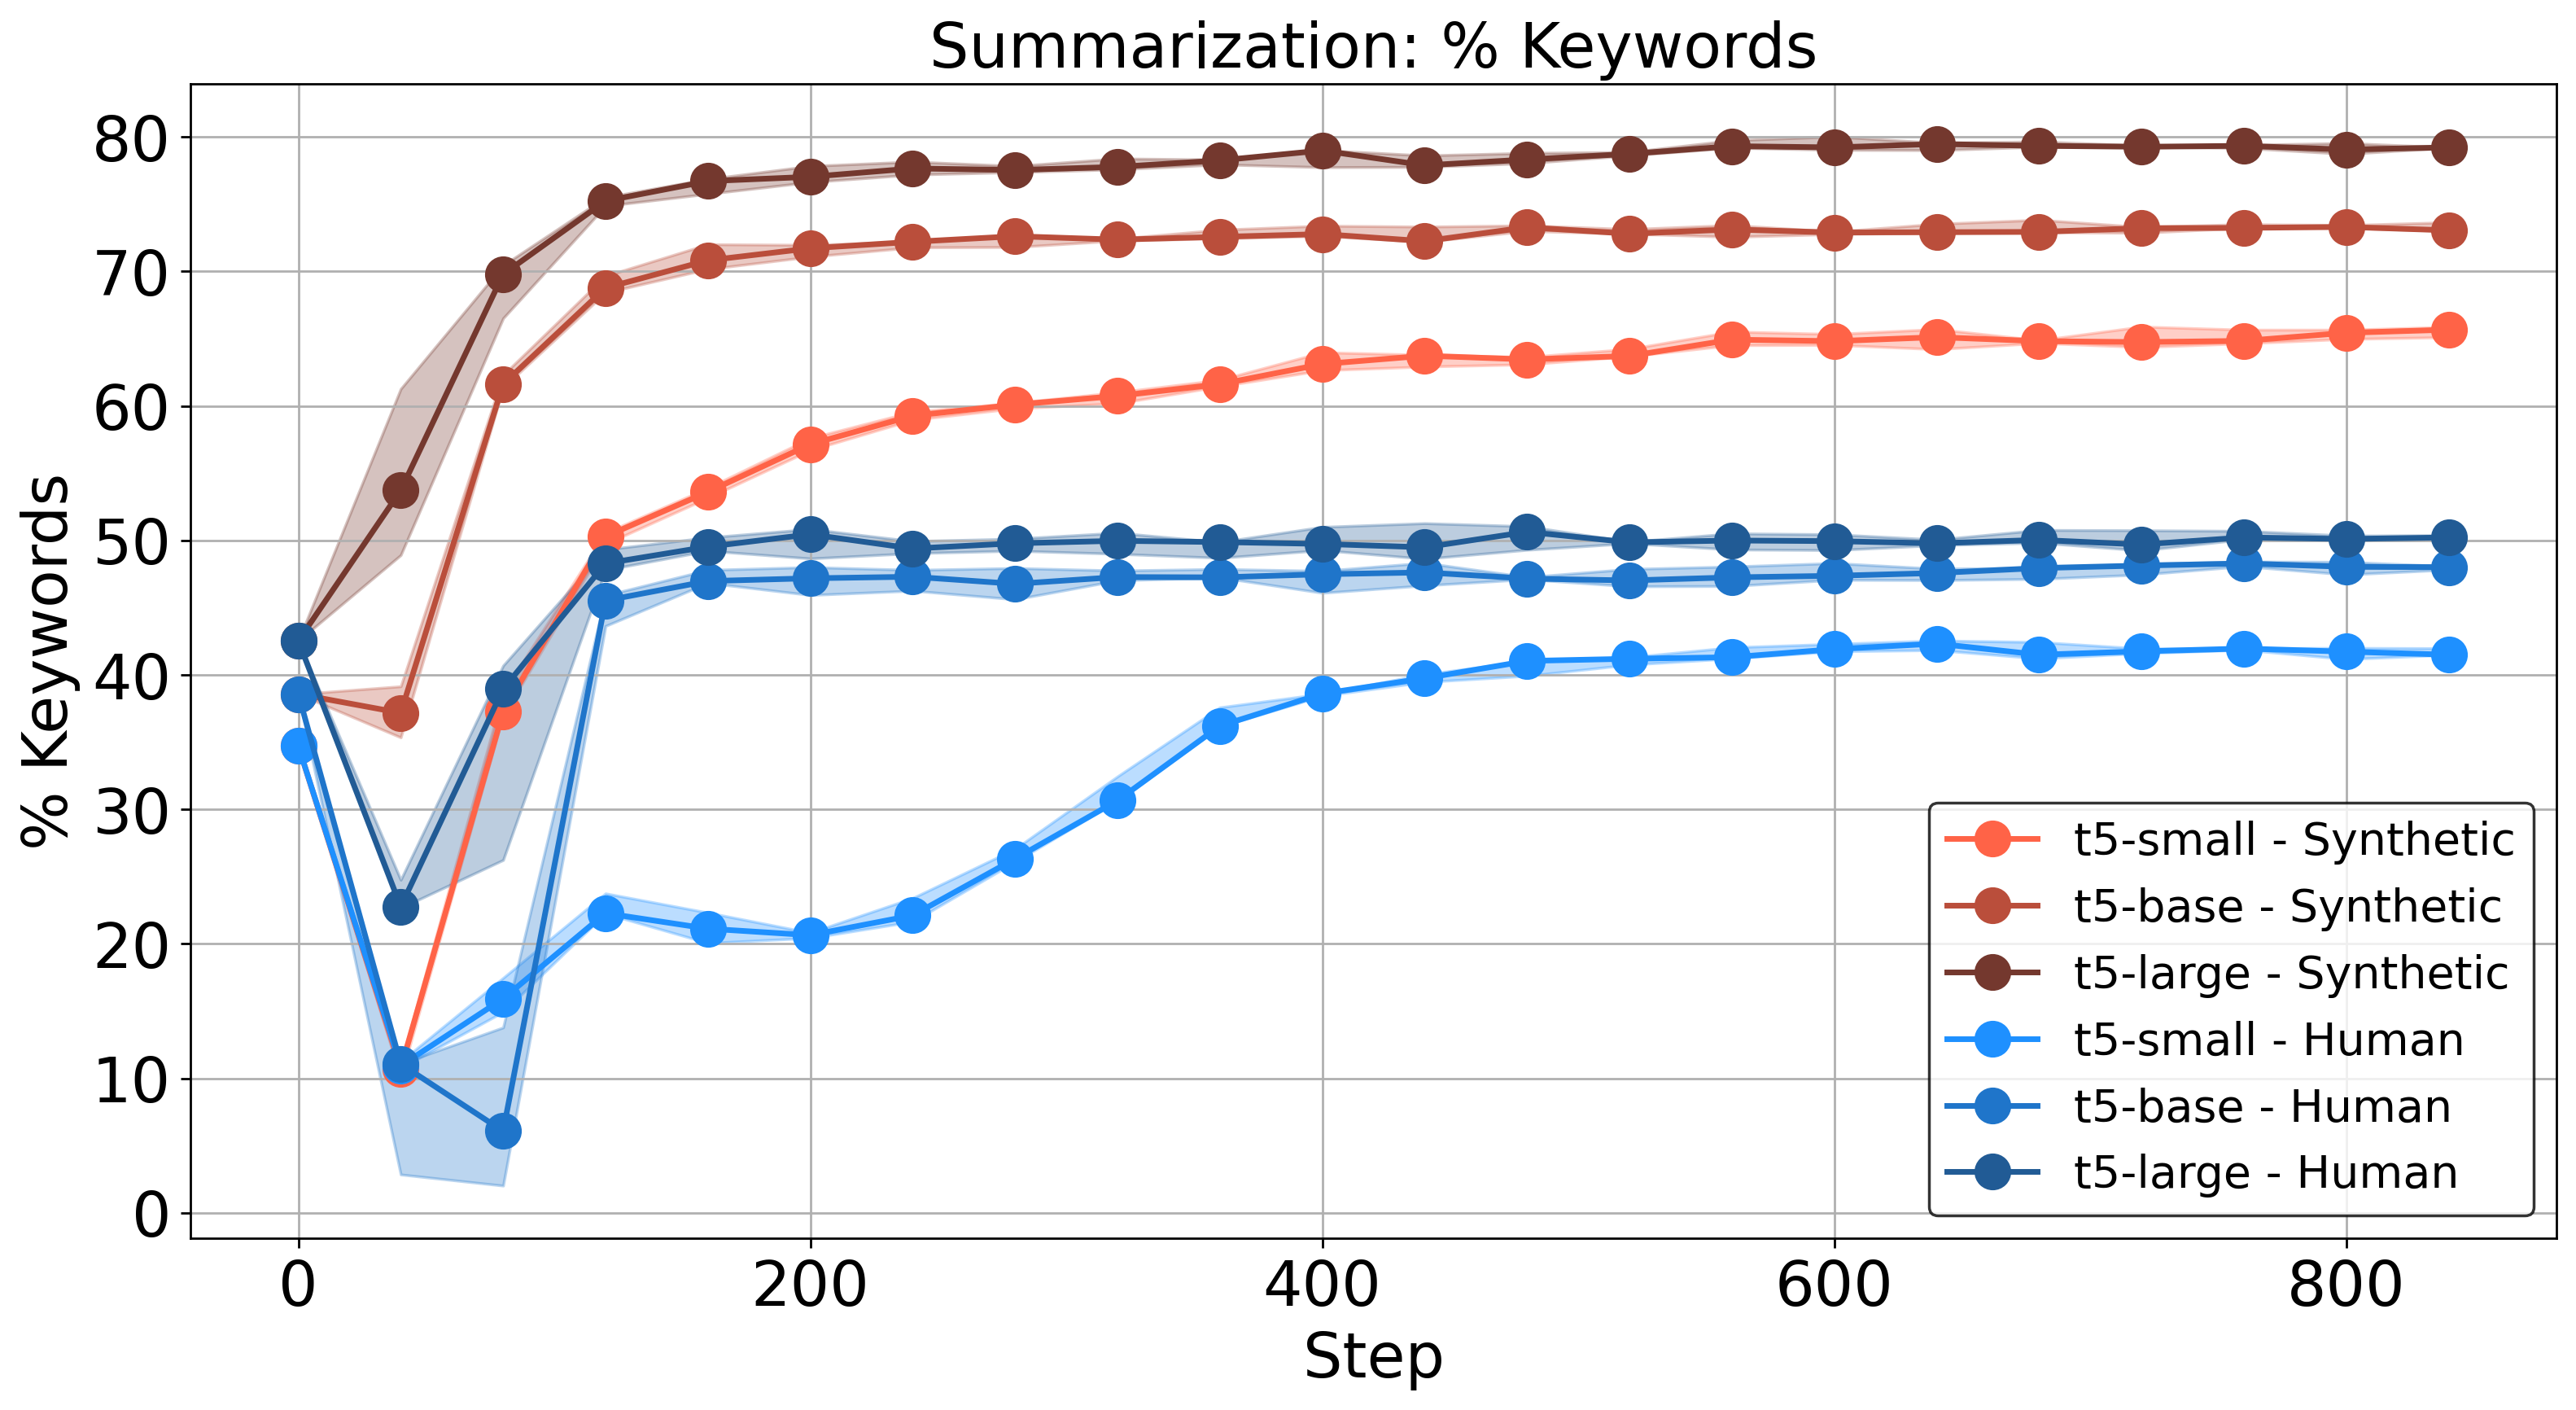

In [12]:
# Create a dictionary to map models to colors
model_colors = {}
model_order = ["t5-small", "t5-base", "t5-large"]
for i, model in enumerate(model_order):
    model_colors[(model, False)] = warm_colors[i]
    model_colors[(model, True)] = cool_colors[i]

# Sort the summary_grouped DataFrame by model order
summary_grouped['model'] = pd.Categorical(summary_grouped['model'], categories=model_order, ordered=True)
summary_grouped = summary_grouped.sort_values(['model', 'human', 'step'])

# Plotting
plt.figure()
for (model, human), data in summary_grouped.groupby(["model", "human"], observed=True):
    label = f"{model} - {'Human' if human else 'Synthetic'}"
    color = model_colors[(model, human)]
    plt.plot(data["step"], data["median_keyword_pct"], label=label, color=color, marker='o', linewidth=2, markersize=12)
    plt.fill_between(data["step"], data["min_keyword_pct"], data["max_keyword_pct"], color=color, alpha=0.3)

plt.xlabel("Step")
plt.ylabel("% Keywords")
plt.title("Summarization: % Keywords")

# Sort legend
handles, labels = plt.gca().get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: (x[1].split(' - ')[1] == 'Human', model_order.index(x[1].split(' - ')[0])))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
plt.legend(sorted_handles, sorted_labels, facecolor='white', edgecolor='black')

plt.show()


In [13]:
summary_baseline["model"] = summary_baseline[0].apply(lambda x: "-".join(x.split("/")[1].split("-")[1:]))
summary_temp = summary_baseline[["model", 1]].rename(columns={1: "max_keyword_pct"})
summary_temp["type"] = -1

max_keyword_pct_row = summary_grouped.loc[summary_grouped.groupby(['model', 'human'], observed=True)["max_keyword_pct"].idxmax()]
max_keyword_pct_row[['model', 'human', 'step', 'max_keyword_pct']]
max_keyword_pct_row['human'] = max_keyword_pct_row['human'].astype(int)
max_keyword_pct_row.rename(columns={'human': 'type'}, inplace=True)
best_summary_comparison = pd.concat([max_keyword_pct_row, summary_temp]).sort_values(["model", "type"])
type_mapping = {-1: 'Baseline', 0: 'Synthetic', 1: 'Human-Generated'}
best_summary_comparison['type'] = best_summary_comparison['type'].map(type_mapping)
best_summary_comparison = best_summary_comparison.sort_values(by=['model', 'type'], key=lambda x: x.map({'Baseline': 0, 'Synthetic': 1, 'Human-Generated': 2}))
best_summary_comparison['model'] = pd.Categorical(best_summary_comparison['model'], categories=['t5-small', 't5-base', 't5-large'], ordered=True)
best_summary_comparison = best_summary_comparison.sort_values(['model', 'type'])

In [14]:
max_keyword_pct_row[['model', 'type', 'step', 'max_keyword_pct']].groupby("model", observed=True)["max_keyword_pct"].apply(lambda x: (x.iloc[0] / x.iloc[1] - 1) * 100)

model
t5-small    54.840454
t5-base     52.471483
t5-large    56.059246
Name: max_keyword_pct, dtype: float64

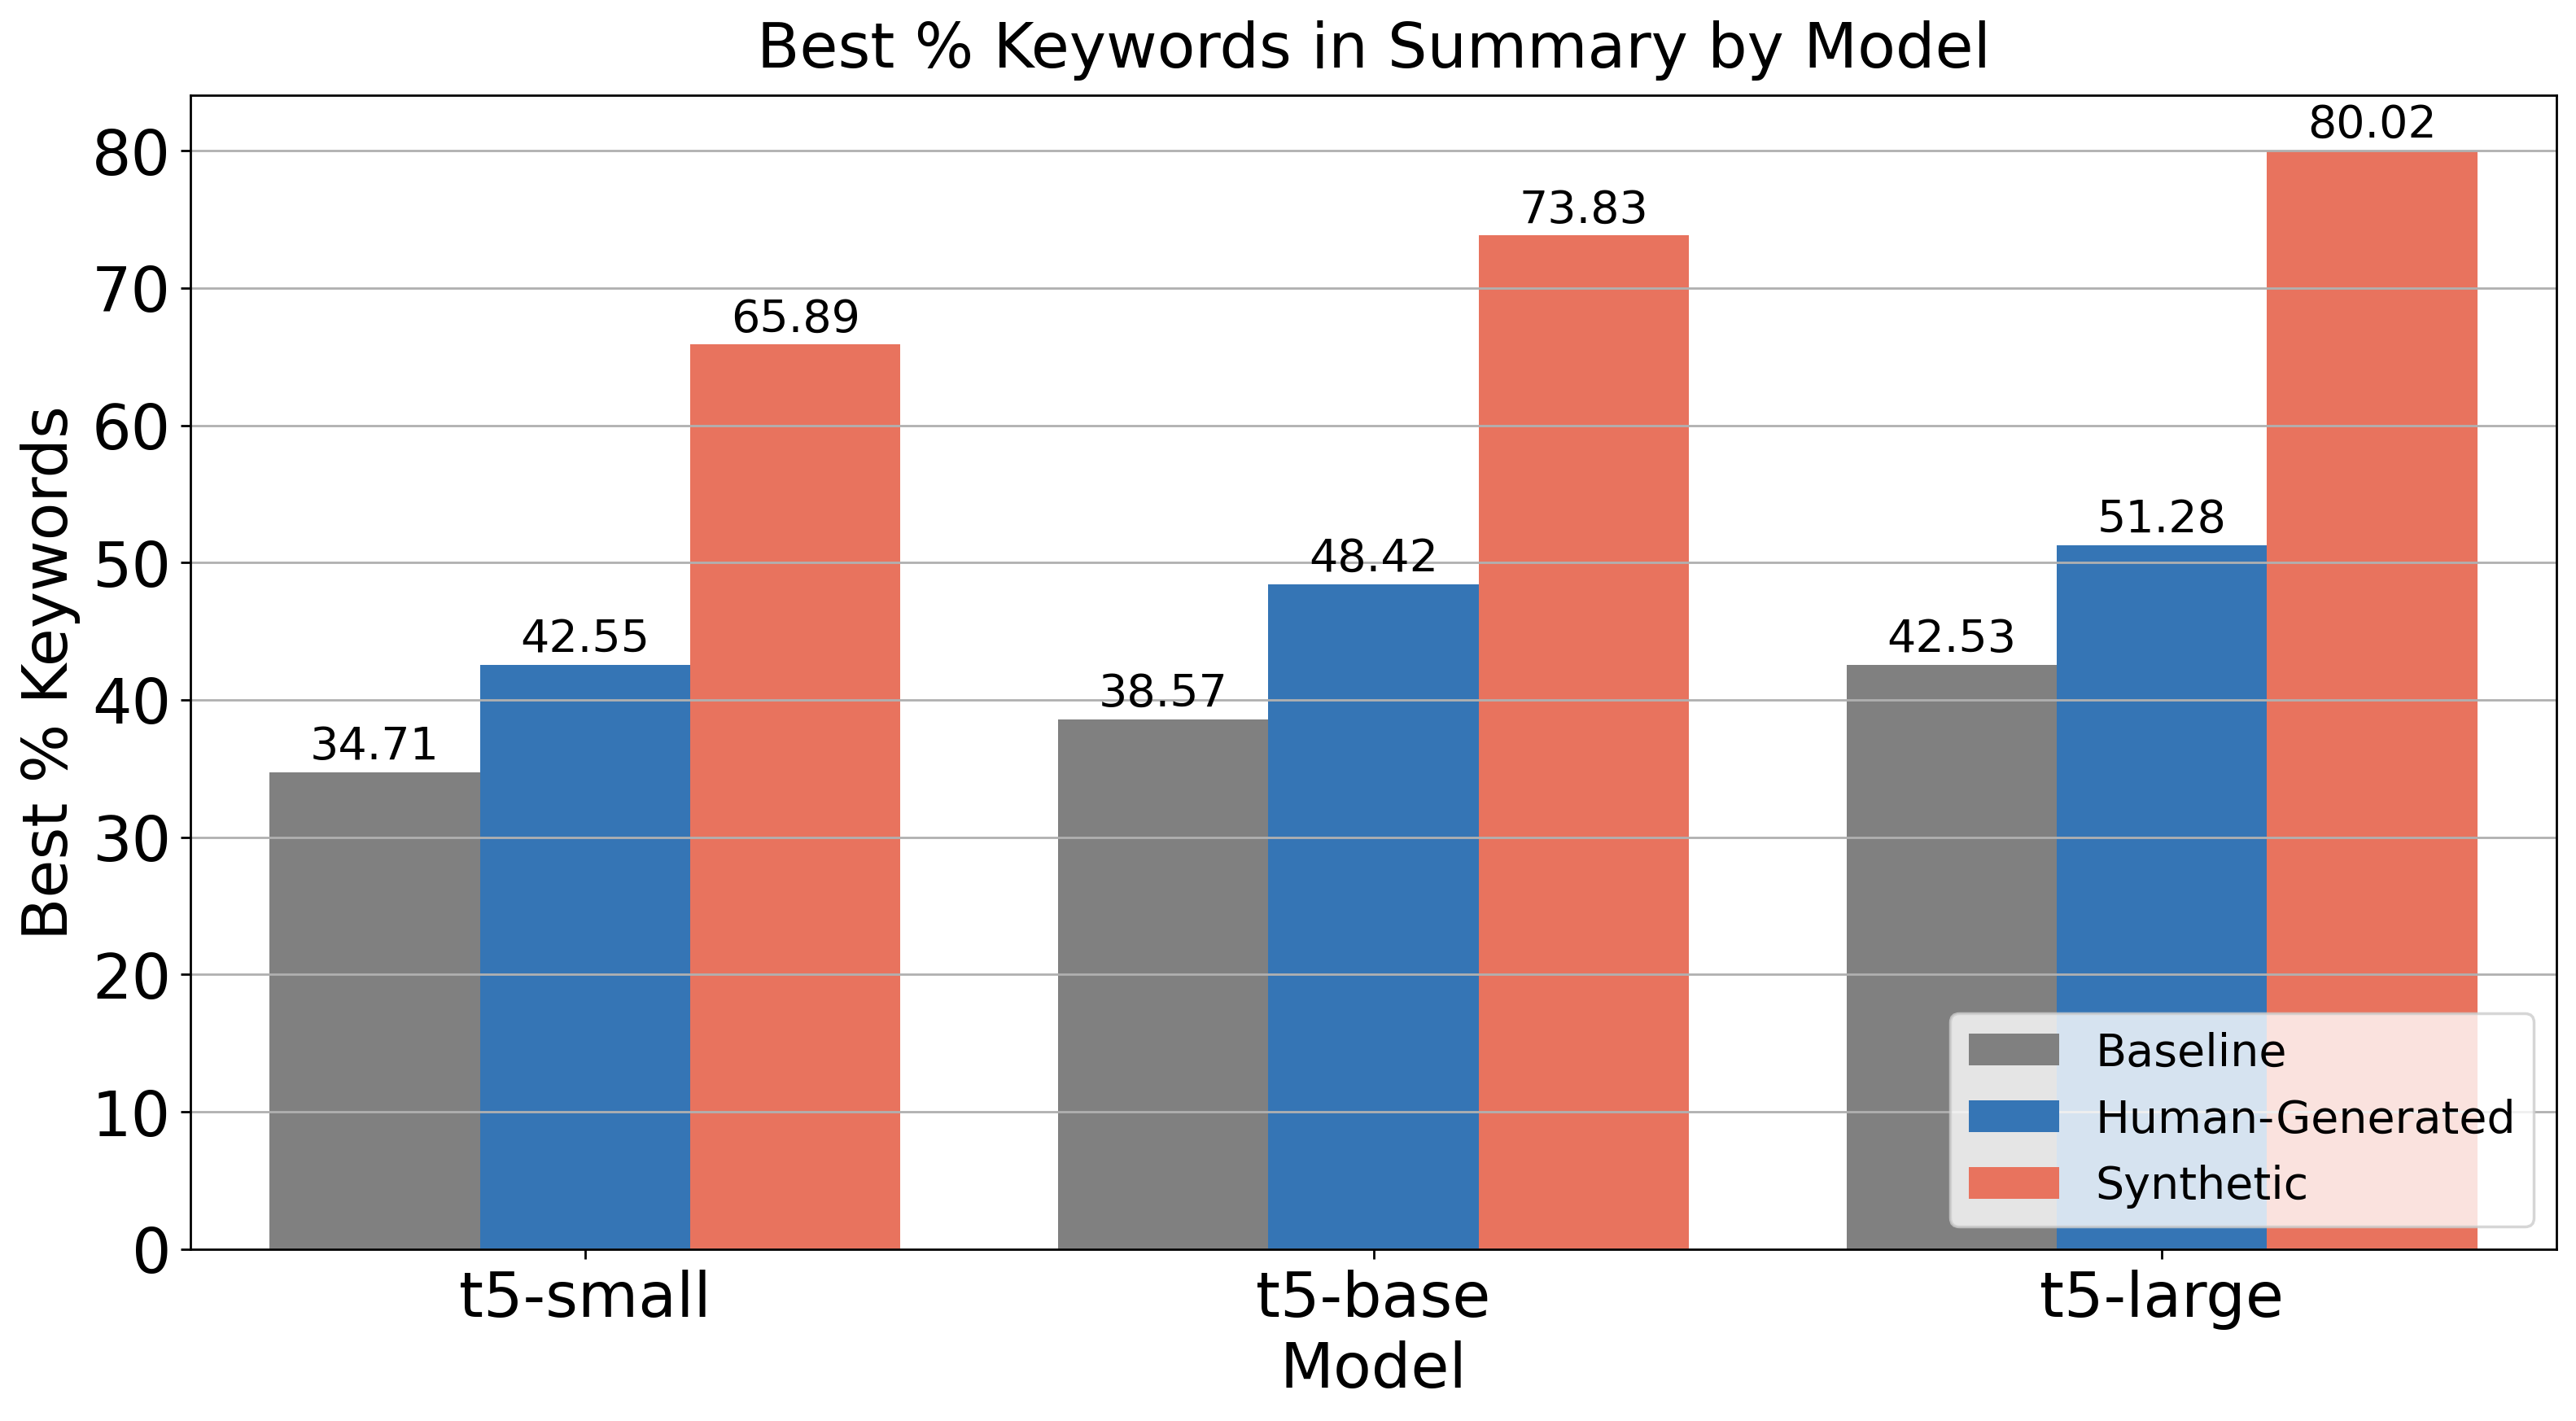

In [15]:
# Define custom palette
custom_palette = {
    'Baseline': 'gray',
    'Synthetic': warm_colors[0],
    'Human-Generated': cool_colors[1]
}

# Plotting
ax = sns.barplot(
    data=best_summary_comparison,
    x="model",
    y="max_keyword_pct",
    hue="type",
    palette=custom_palette
)

# Add bar labels
for p in ax.patches:
    if p.get_height() > 0:  # Skip labels with height 0
        ax.annotate(format(p.get_height(), '.2f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=16)  # Increase font size

plt.legend(title=None, loc="lower right")
plt.ylabel("Best % Keywords")
plt.xlabel("Model")
plt.title("Best % Keywords in Summary by Model", pad=10)
plt.show()


In [16]:
max_keyword_pct_row = summary_grouped.loc[summary_grouped.groupby(['model', 'human'], observed=True)["min_loss"].idxmin()]
max_keyword_pct_row[['model', 'human', 'step', 'min_loss']]

,model,human,step,min_loss
108,t5-small,False,800,1.1875
131,t5-small,True,840,0.5885
20,t5-base,False,800,0.9039
43,t5-base,True,840,0.4729
63,t5-large,False,760,0.7060
87,t5-large,True,840,0.3999


## Q&A

In [194]:
qna_path = os.path.join(eval_path, "qna")
qna_jobs = listdir(qna_path, exclude=[".DS_Store", 'args.json', 'baseline.csv'])
qna_baseline = pd.read_csv(os.path.join(qna_path, "baseline.csv"), header=None)

In [195]:
qna_df = []

for job in qna_jobs:
    df = pd.read_csv(os.path.join(job, "evaluation_results.csv"), header=None)
    df.columns = ["checkpoint_name", "accuracy"]
    df["step"] = df["checkpoint_name"].apply(lambda x: int(x.split("-")[-1]))
    df.drop("checkpoint_name", axis=1, inplace=True)

    # add baseline
    baseline_accuracy = qna_baseline.loc[qna_baseline[0] == f"google/flan-{job.split("/")[-1].split("_")[0]}", 1].values[0]
    df = pd.concat([pd.DataFrame({"accuracy": [baseline_accuracy], "step": [0]}), df], ignore_index=True)

    df["model"] = job.split("/")[-1].split("_")[0]
    df["human"] = "human" in job

    loss_df = pd.read_csv(os.path.join(loss_path, "qna", "cleaned", f"{os.path.basename(job)}_train.csv"))
    df = df.merge(loss_df[['step', 'loss']], on='step', how='left')

    qna_df.append(df)

qna_df = pd.concat(qna_df)

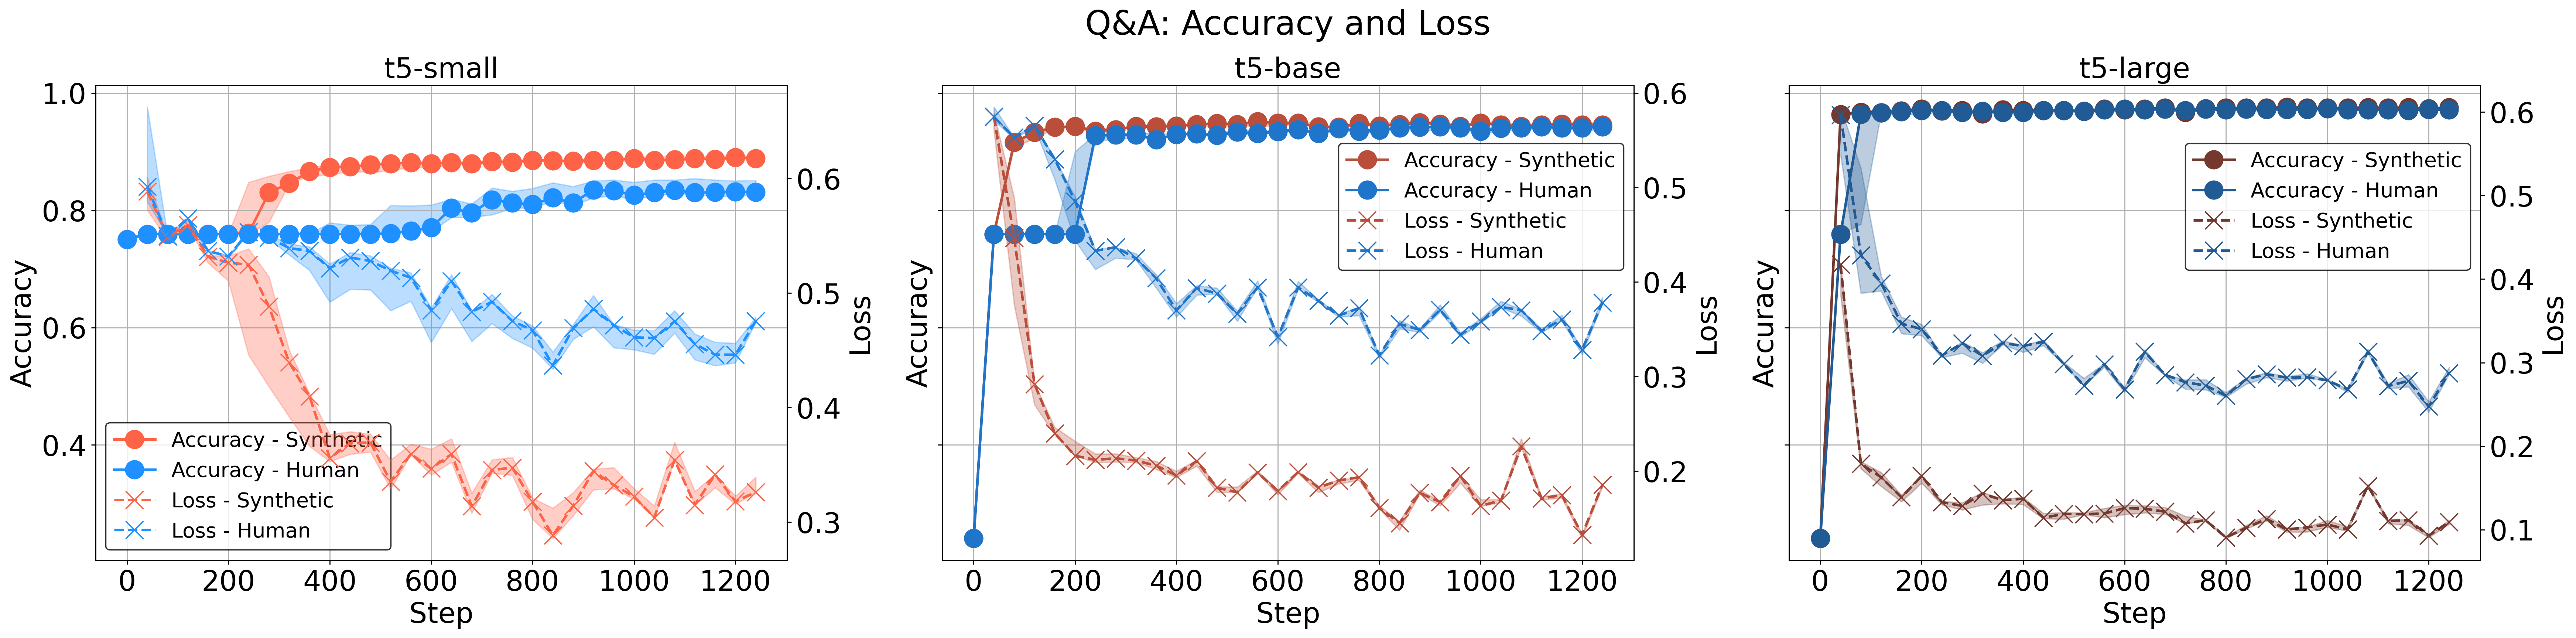

In [196]:
# Group by model and human, then calculate min, median, and max
qna_grouped = qna_df.groupby(["model", "human", "step"]).agg({"accuracy": ["min", "median", "max"], "loss": ["min", "median", "max"]}).reset_index()
qna_grouped.columns = ["model", "human", "step", "min_accuracy", "median_accuracy", "max_accuracy", "min_loss", "median_loss", "max_loss"]

# Create a dictionary to map models to colors
model_colors = {}
model_order = ["t5-small", "t5-base", "t5-large"]
for i, model in enumerate(model_order):
    model_colors[(model, False)] = warm_colors[i]
    model_colors[(model, True)] = cool_colors[i]

# Sort the qna_grouped DataFrame by model order
qna_grouped['model'] = pd.Categorical(qna_grouped['model'], categories=model_order, ordered=True)
qna_grouped = qna_grouped.sort_values(['model', 'human', 'step'])

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 7), sharex=True, sharey=True)
axes = axes.flatten()

# Plotting
for idx, model in enumerate(model_order):
    ax2 = axes[idx].twinx()  # Create secondary axis once per subplot
    for human in [False, True]:
        data = qna_grouped[(qna_grouped["model"] == model) & (qna_grouped["human"] == human)]
        label_accuracy = f"Accuracy - {'Human' if human else 'Synthetic'}"
        label_loss = f"Loss - {'Human' if human else 'Synthetic'}"
        color = model_colors[(model, human)]
        axes[idx].plot(data["step"], data["median_accuracy"], label=label_accuracy, color=color, marker='o', linestyle='-', markersize=14, linewidth=2)
        axes[idx].fill_between(data["step"], data["min_accuracy"], data["max_accuracy"], color=color, alpha=0.3)
        ax2.plot(data["step"], data["median_loss"], label=label_loss, color=color, linestyle='--', marker='x', markersize=14, linewidth=2)
        ax2.fill_between(data["step"], data["min_loss"], data["max_loss"], color=color, alpha=0.3)
        ax2.set_ylabel("Loss")
        axes[idx].set_title(model)
        axes[idx].set_xlabel("Step")
        axes[idx].set_ylabel("Accuracy")
    ax2.grid(False)

    # Combine legends
    lines, labels = axes[idx].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    if idx == 0:
        axes[idx].legend(lines + lines2, labels + labels2, loc='lower left', edgecolor='black')
    else:
        axes[idx].legend(lines + lines2, labels + labels2, loc='upper right', bbox_to_anchor=(1, 0.9), edgecolor='black')

plt.suptitle("Q&A: Accuracy and Loss")
plt.tight_layout()
plt.show()

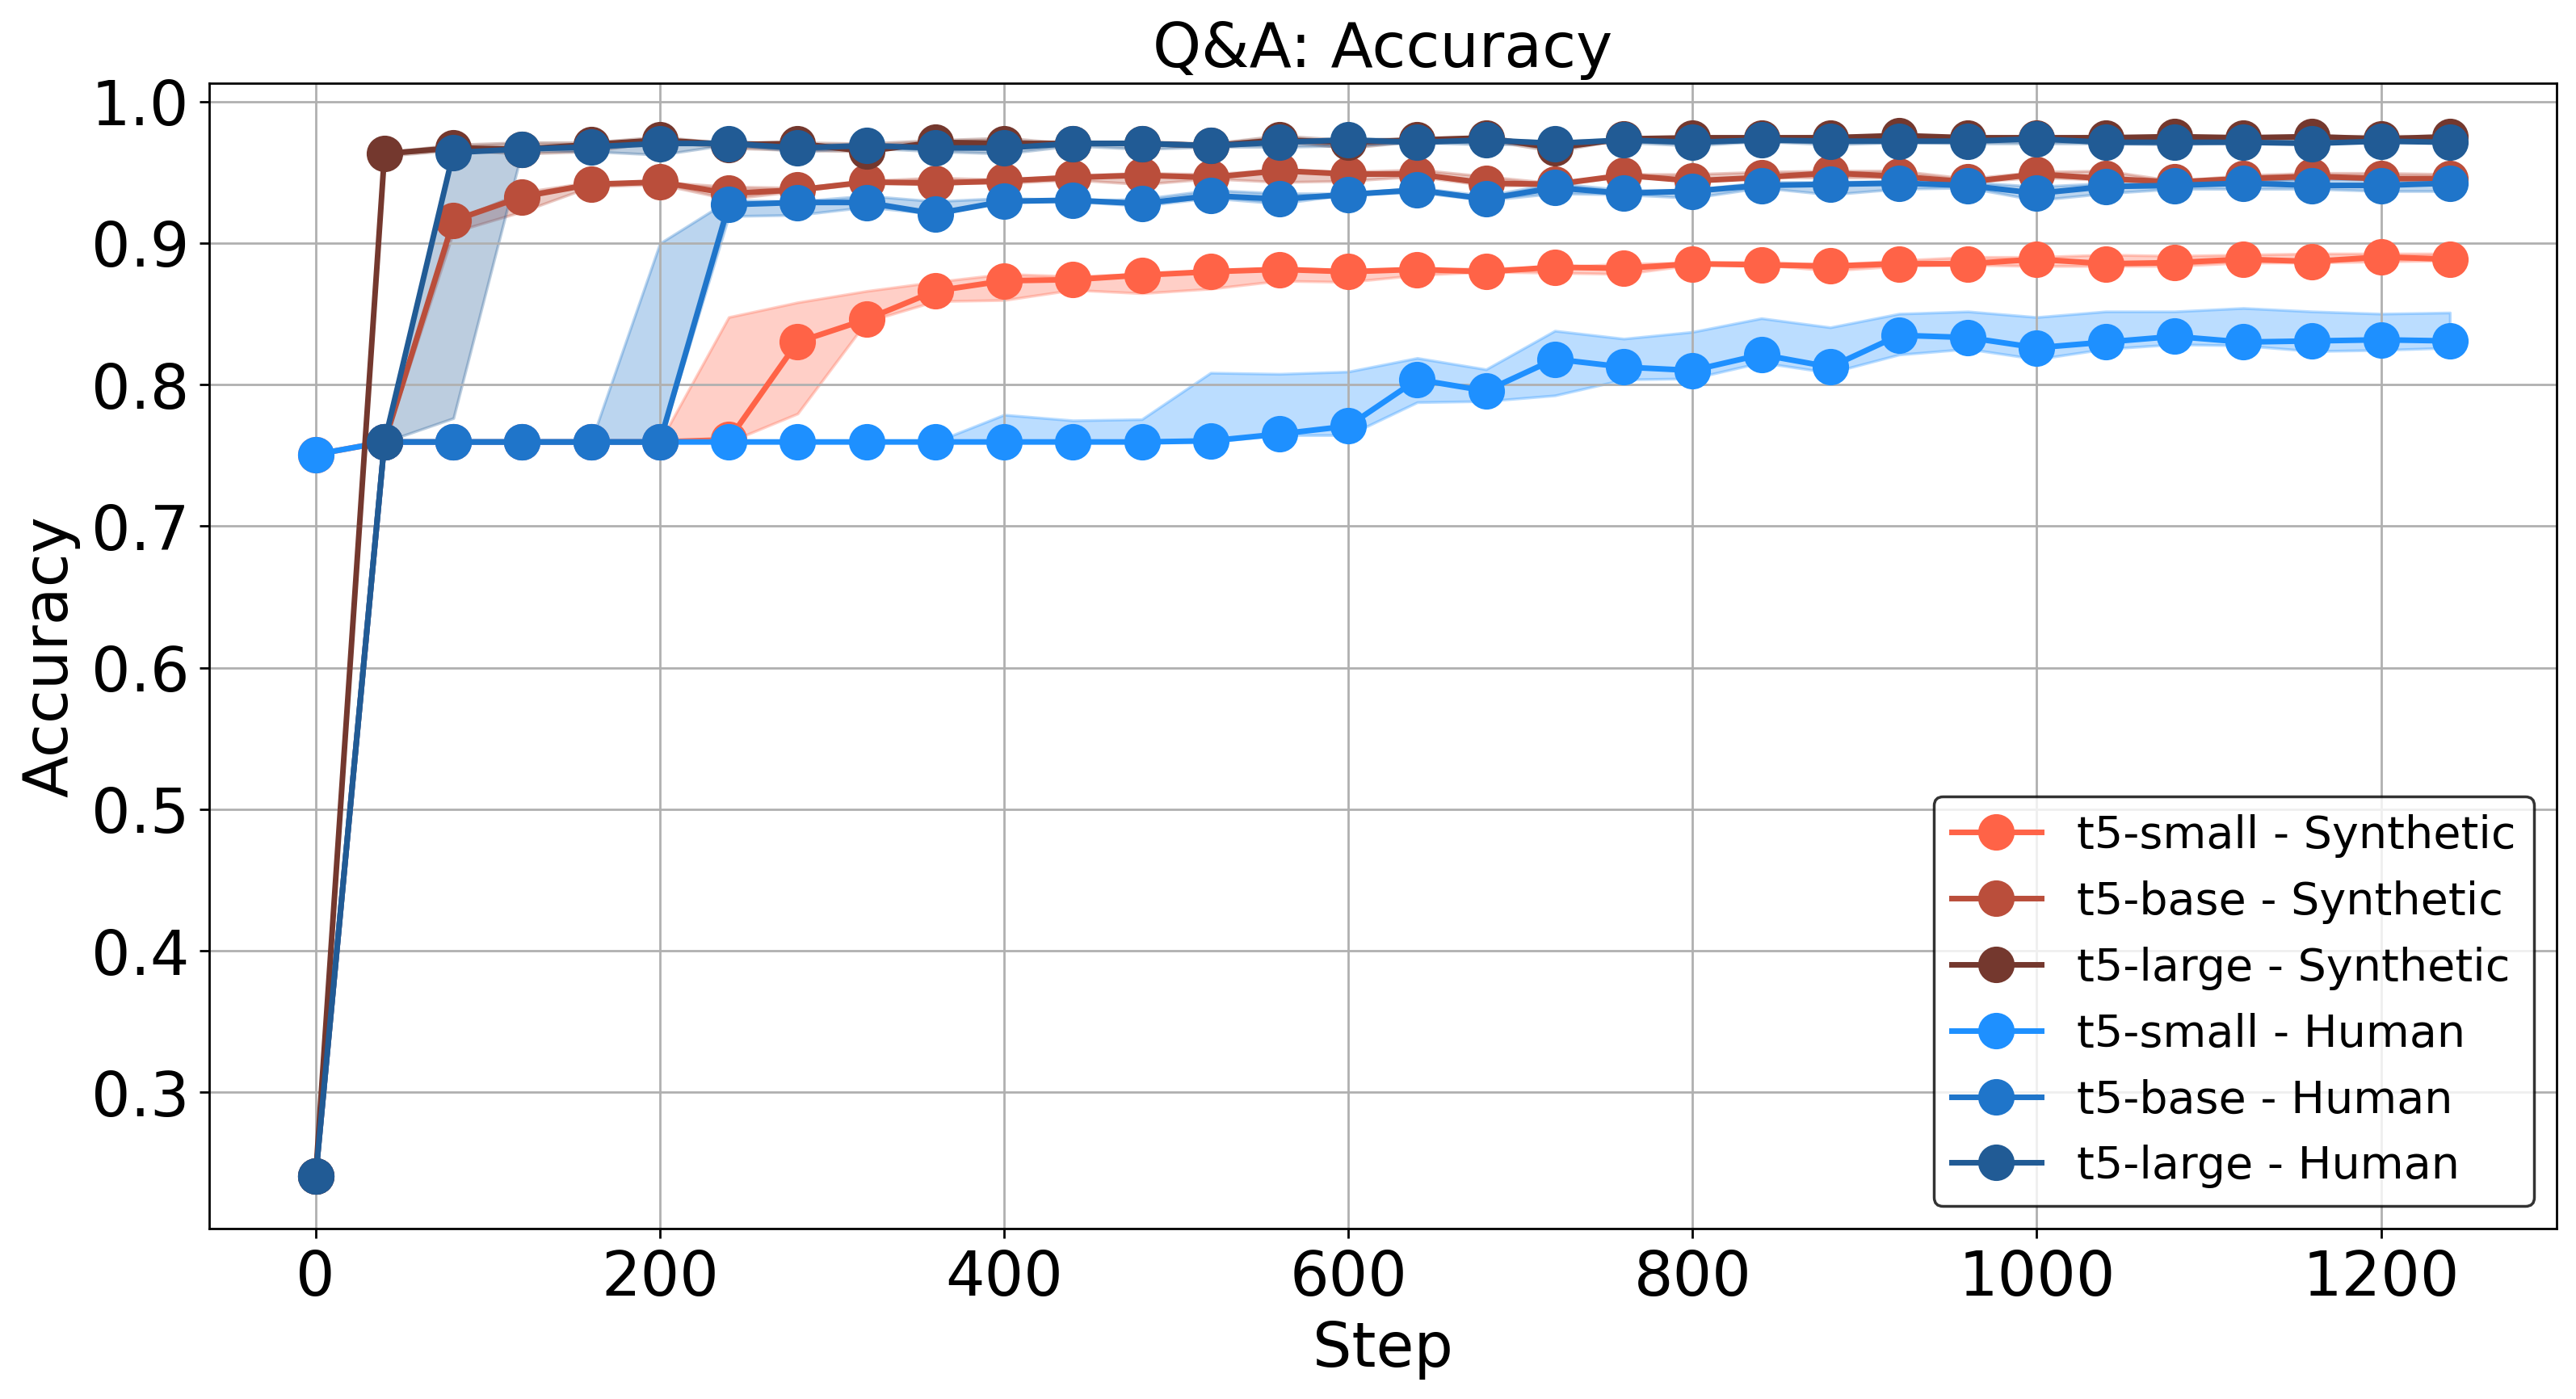

In [197]:
# Plotting
plt.figure()
for (model, human), data in qna_grouped.groupby(["model", "human"], observed=True):
    label = f"{model} - {'Human' if human else 'Synthetic'}"
    color = model_colors[(model, human)]
    plt.plot(data["step"], data["median_accuracy"], label=label, color=color, marker='o', linewidth=2, markersize=12)
    plt.fill_between(data["step"], data["min_accuracy"], data["max_accuracy"], color=color, alpha=0.3)

plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Q&A: Accuracy")

# Sort legend
handles, labels = plt.gca().get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: (x[1].split(' - ')[1] == 'Human', model_order.index(x[1].split(' - ')[0])))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
plt.legend(sorted_handles, sorted_labels, edgecolor='black')

plt.show()

In [198]:
qna_baseline["model"] = qna_baseline[0].apply(lambda x: "-".join(x.split("/")[1].split("-")[1:]))
qna_temp = qna_baseline[["model", 1]].rename(columns={1: "max_accuracy"})
qna_temp["type"] = -1

max_accuracy_row = qna_grouped.loc[qna_grouped.groupby(['model', 'human'], observed=True)["max_accuracy"].idxmax()]
max_accuracy_row[['model', 'human', 'step', 'max_accuracy']]
max_accuracy_row['human'] = max_accuracy_row['human'].astype(int)
max_accuracy_row.rename(columns={'human': 'type'}, inplace=True)
best_qna_comparison = pd.concat([max_accuracy_row, qna_temp]).sort_values(["model", "type"])
type_mapping = {-1: 'Baseline', 0: 'Synthetic', 1: 'Human-Generated'}
best_qna_comparison['type'] = best_qna_comparison['type'].map(type_mapping)
best_qna_comparison = best_qna_comparison.sort_values(by=['model', 'type'], key=lambda x: x.map({'Baseline': 0, 'Synthetic': 1, 'Human-Generated': 2}))
best_qna_comparison['model'] = pd.Categorical(best_qna_comparison['model'], categories=['t5-small', 't5-base', 't5-large'], ordered=True)
best_qna_comparison = best_qna_comparison.sort_values(['model', 'type'])

In [199]:
max_accuracy_row[['model', 'type', 'step', 'max_accuracy']].groupby("model", observed=True)["max_accuracy"].apply(lambda x: (x.iloc[0] / x.iloc[1] - 1) * 100)

model
t5-small    4.507042
t5-base     0.678541
t5-large    0.082237
Name: max_accuracy, dtype: float64

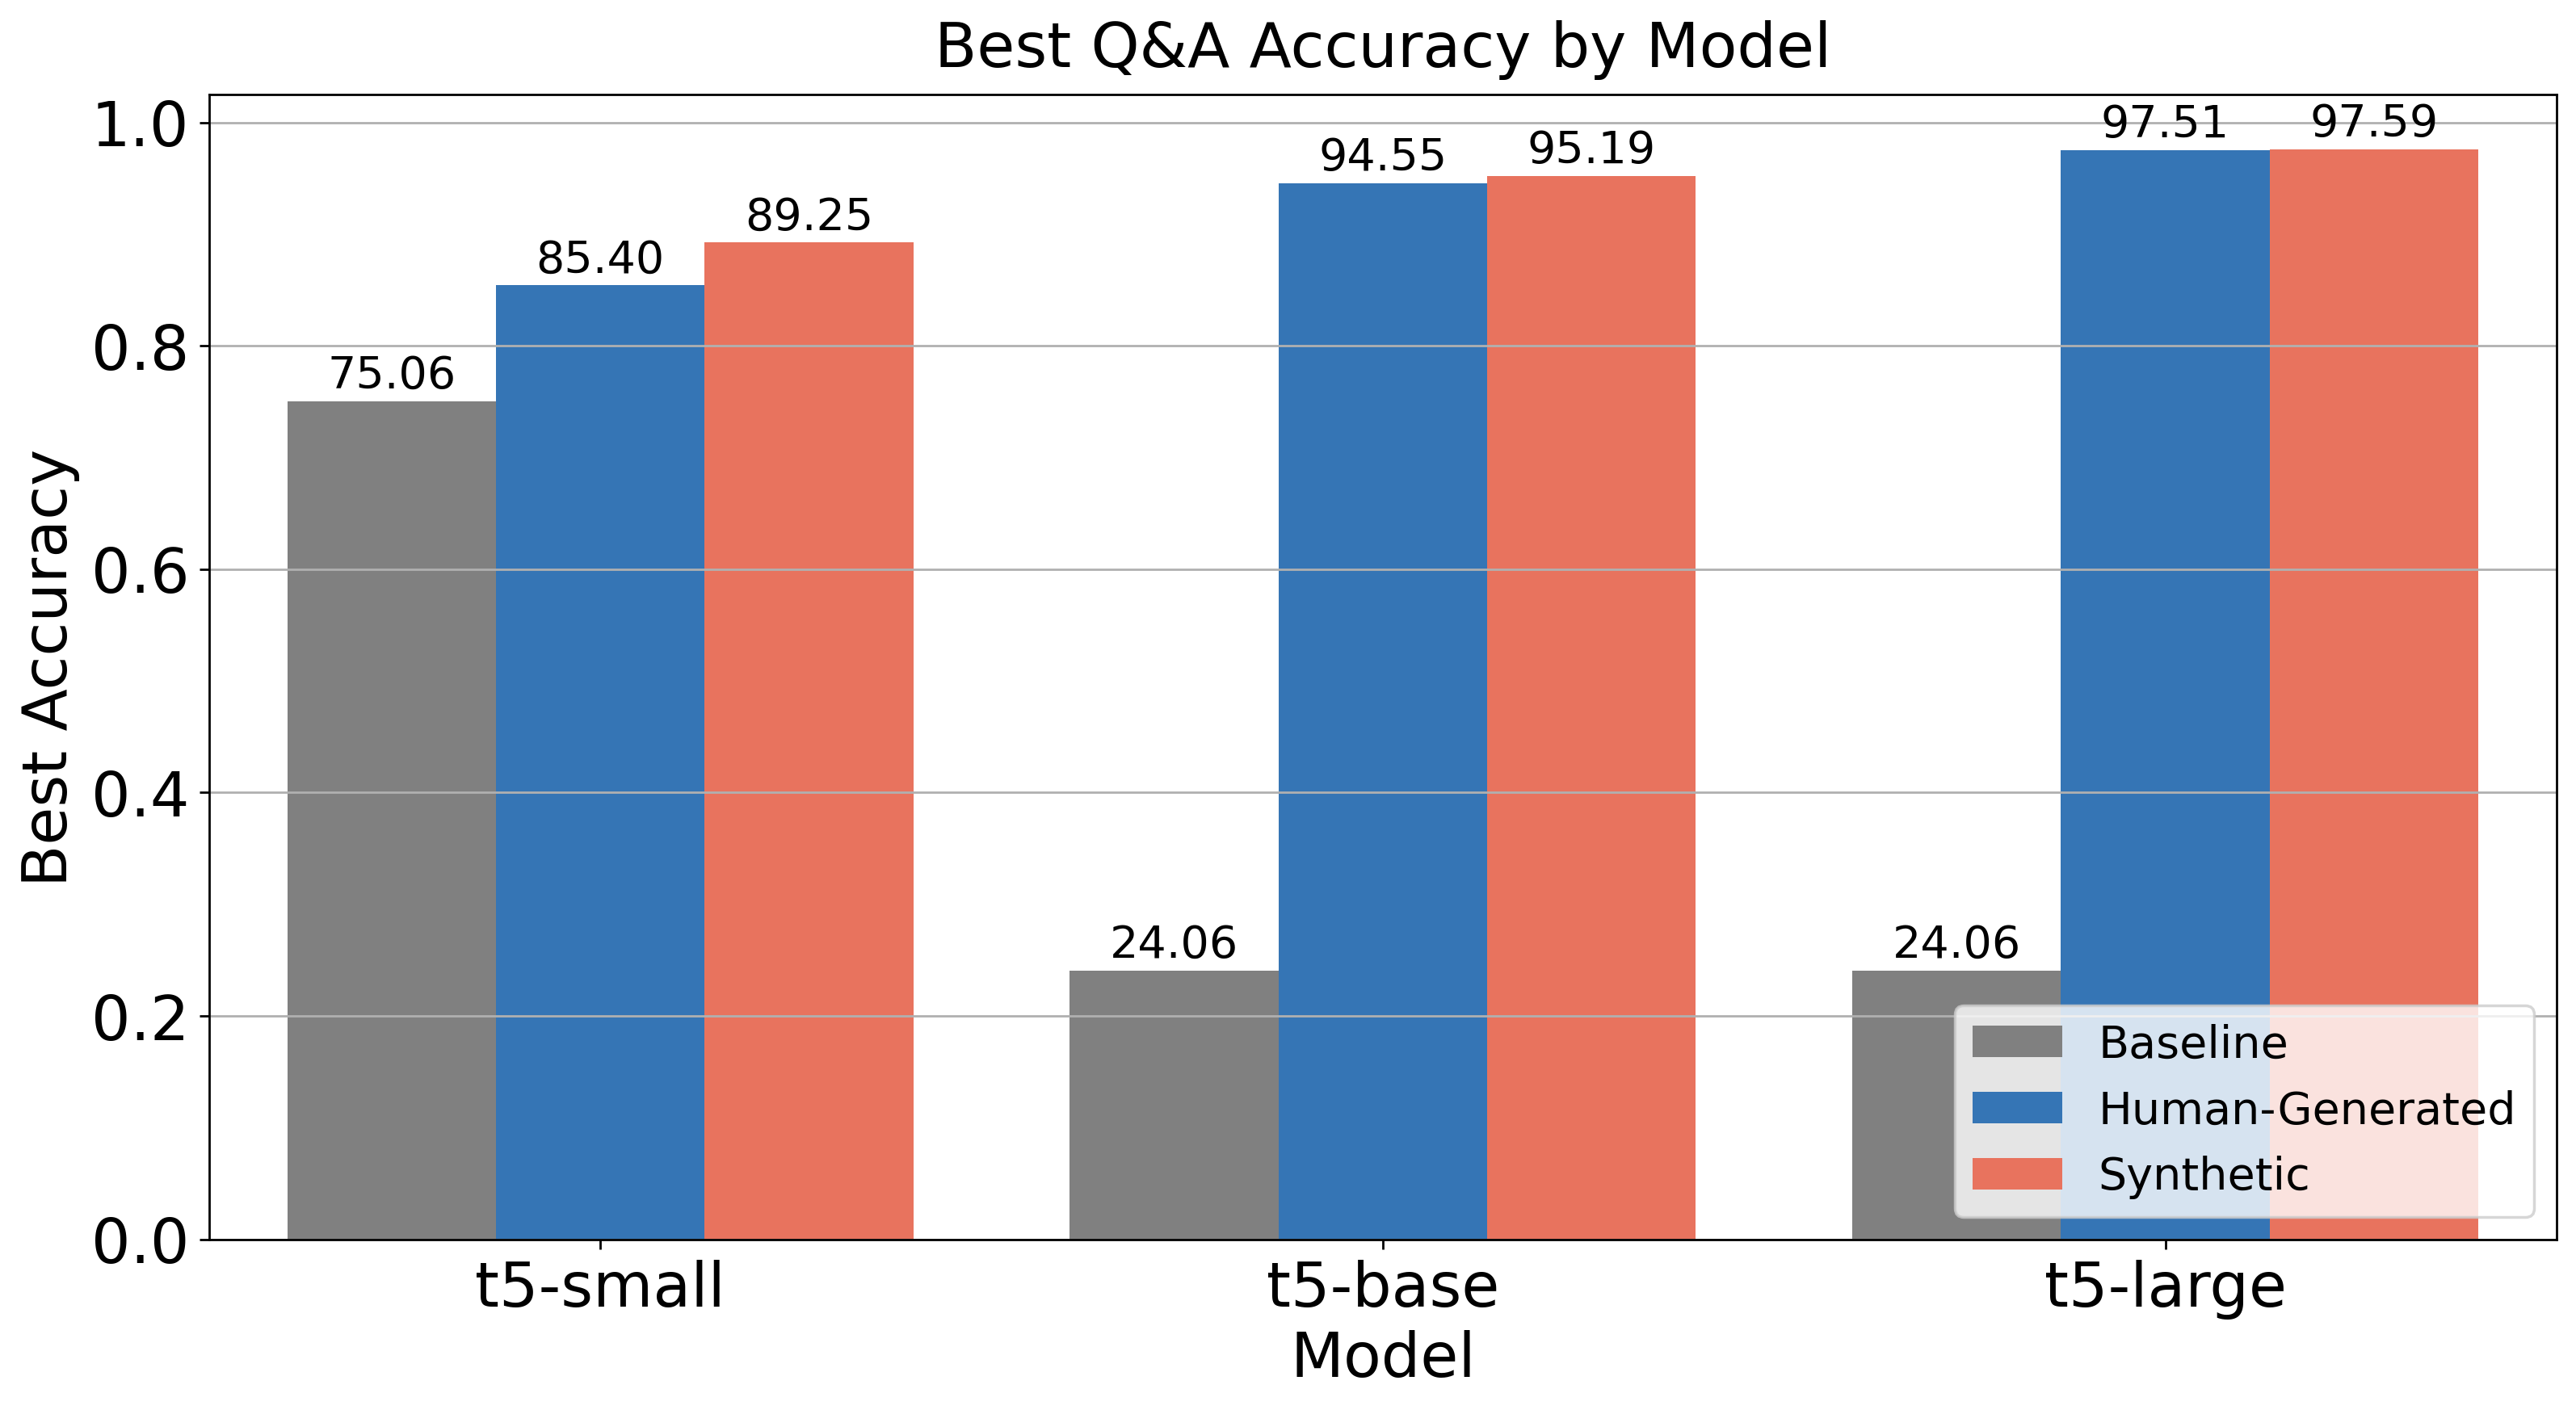

In [200]:
# Define custom palette
custom_palette = {
    'Baseline': 'gray',
    'Synthetic': warm_colors[0],
    'Human-Generated': cool_colors[1]
}

# Plotting
ax = sns.barplot(
    data=best_qna_comparison,
    x="model",
    y="max_accuracy",
    hue="type",
    palette=custom_palette
)

# Add bar labels
for p in ax.patches:
    if p.get_height() > 0:  # Skip labels with height 0
        ax.annotate(format(p.get_height()*100, '.2f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=16)  # Increase font size

plt.legend(title=None, loc="lower right")
plt.ylabel("Best Accuracy")
plt.xlabel("Model")
plt.title("Best Q&A Accuracy by Model", pad=10)
plt.show()


In [201]:
min_loss_row = qna_grouped.loc[qna_grouped.groupby(['model', 'human'], observed=True)["min_loss"].idxmin()]
min_loss_row[['model', 'human', 'step', 'min_loss']]

,model,human,step,min_loss
149,t5-small,False,840,0.2857
181,t5-small,True,840,0.4335
30,t5-base,False,1200,0.1288
52,t5-base,True,800,0.3193
84,t5-large,False,800,0.0895
126,t5-large,True,1200,0.2408
